# Residency Valuation using Advanced Regression Modeling

#### Importing Required libraries

In [271]:
import numpy as np
import csv
import pandas as pd 
# from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
import csv
# !pip install xgboost
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , RandomizedSearchCV,  GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer


In [308]:
## reading csv 
train = pd.read_csv('train.csv')                          

test = pd.read_csv('test.csv')


train.drop(['Id'],axis=1,inplace=True)

## performing EDA ( Explorative Data Analysis )

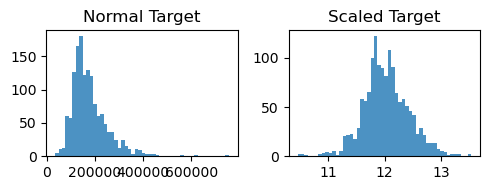

In [309]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2))  # Adjust figsize as needed

# First subplot for the normal target
axes[0].hist(train["SalePrice"], bins=50, alpha=0.8)
axes[0].set_title("Normal Target")

# Second subplot for the scaled target
axes[1].hist(np.log1p(train["SalePrice"]), bins=50, alpha=0.8)
axes[1].set_title("Scaled Target")

# Show the plots
plt.tight_layout()
plt.show()

In [310]:
train["SalePrice"]=np.log1p(train.SalePrice)

- But now we have to make sure our prediction is reversed by appling the reverse function (np.exp)

In [311]:
# train_["Age"] = train_.YrSold - train_.YearBuilt

# test_["Age"] = test_.YrSold - test_.YearBuilt

In [312]:
train_.isna().sum().values

array([   0,    0,  259,    0,    0, 1369,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  872,    8,    0,    0,    0,   37,   37,   38,   37,
          0,   38,    0,    0,    0,    0,    0,    0,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  690,   81,   81,   81,    0,    0,   81,   81,    0,    0,
          0,    0,    0,    0,    0, 1453, 1179, 1406,    0,    0,    0,
          0,    0])

 ### performing effectrive feature Engineering
 

In [313]:
train.fillna(0,inplace=True)      
test.fillna(0,inplace=True)


y_train = train['SalePrice']

# ONE-HOT encoding categorical features

traincol = train.select_dtypes(include = ['object']).columns.tolist()
testcol= test.select_dtypes(include = ['object']).columns.tolist()


train_int =train.select_dtypes(include = ['int']).columns.tolist()
train = pd.get_dummies(train,traincol).astype(int)
X_test = pd.get_dummies(test,testcol).astype(int)

# Droping the target variable from the features
X_train = train
X_train.drop('SalePrice',axis=1,inplace=True)

In [314]:

X_train.shape == X_test.shape


False

In [315]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65,8450,7,5,2003,2003,196,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80,9600,6,8,1976,1976,0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68,11250,7,5,2001,2002,162,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60,9550,7,5,1915,1970,0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84,14260,8,5,2000,2000,350,655,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62,7917,6,5,1999,2000,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,20,85,13175,6,6,1978,1988,119,790,163,...,0,0,0,1,0,0,0,0,1,0
1457,70,66,9042,7,9,1941,2006,0,275,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68,9717,5,6,1950,1996,0,49,1029,...,0,0,0,1,0,0,0,0,1,0


In [316]:
def FIXfeat(df):
    df['TotalSqFt'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']


    df['HasGarage'] = ((df['GarageArea'] > 0) | (df['GarageCars'] > 0)).astype(int)

    df['HasPool'] = (df['PoolArea'] > 0).astype(int)

    df['TotalBathrooms'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])

    df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    
    return df


X_train = FIXfeat(X_train)
X_test = FIXfeat(X_test)
X_train,X_test = X_train.align(X_test,axis=1,fill_value=0)

X_train.shape[1] == X_test.shape[1]

True

In [317]:
X_train

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley_0,Alley_Grvl,Alley_Pave,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,...,TotalBsmtSF,TotalPorchArea,TotalSqFt,Utilities_0,Utilities_AllPub,Utilities_NoSeWa,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,0,0,3,1,0,0,...,856,61,2566,0,1,0,0,2003,2003,2008
1,1262,0,0,1,0,0,3,1,0,0,...,1262,0,2524,0,1,0,298,1976,1976,2007
2,920,866,0,1,0,0,3,1,0,0,...,920,42,2706,0,1,0,0,2001,2002,2008
3,961,756,0,1,0,0,3,1,0,0,...,756,307,2473,0,1,0,0,1915,1970,2006
4,1145,1053,0,1,0,0,4,1,0,0,...,1145,84,3343,0,1,0,192,2000,2000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,0,1,0,0,3,1,0,0,...,953,40,2600,0,1,0,0,1999,2000,2007
1456,2073,0,0,1,0,0,3,1,0,0,...,1542,0,3615,0,1,0,349,1978,1988,2010
1457,1188,1152,0,1,0,0,4,1,0,0,...,1152,60,3492,0,1,0,0,1941,2006,2010
1458,1078,0,0,1,0,0,2,1,0,0,...,1078,112,2156,0,1,0,366,1950,1996,2010


In [318]:
def rmse_log(y_true, y_pred):
    log_y_true = np.log1p(y_true)
    log_y_pred = np.log1p(y_pred)
    squared_diff = (log_y_true - log_y_pred) ** 2
    
    mean_squared_error = np.mean(squared_diff)
    
    rmse = np.sqrt(mean_squared_error)
    return rmse

In [319]:
X_train,X_,y_train,y_=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

# X_,X_val,y_,y_val = train_test_split(X_,y_,test_size=0.5,random_state=42)

best_params = {'subsample': 0.8,
                 'n_estimators': 170,
                 'min_child_weight': 1, 
                 'max_depth': 3, 
                 'learning_rate': 0.05, 
                 'gamma': 0.1,
                 'colsample_bytree': 0.8}


In [320]:
from scipy.stats import uniform, randint


param_dist = {
    'subsample': uniform(0.5, 0.5),          # Range: [0.5, 1.0]
    'n_estimators': [100,170,200, 300],        # Range: [100, 300]
    'min_child_weight': randint(1, 10),       # Range: [1, 10]
    'max_depth': randint(1, 10),              # Range: [1, 10]
    'learning_rate': uniform(0.01, 0.09),     # Range: [0.01, 0.1]
    'gamma': uniform(0, 0.5),                 # Range: [0, 0.5]
    'colsample_bytree': uniform(0.5, 0.5)     # Range: [0.5, 1.0]
}

modele = RandomizedSearchCV(estimator = XGBRegressor(),param_distributions= param_dist,
                            scoring='neg_mean_squared_error',
                            verbose=1,
                            n_iter=100,
                            random_state=42, cv=5).fit(X_train,y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [321]:
best_params = modele.best_params_
print("best_params:" , best_params)

best_params: {'colsample_bytree': 0.5035331526098588, 'gamma': 0.011531212520707879, 'learning_rate': 0.05722971942325503, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 300, 'subsample': 0.7962072844310213}


best_params: {'colsample_bytree': 0.5035331526098588, 'gamma': 0.011531212520707879, 'learning_rate': 0.05722971942325503, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 300, 'subsample': 0.7962072844310213}


In [322]:

model = XGBRegressor(**best_params).fit(X_train,y_train)




In [323]:
yhat = model.predict(X_)

In [327]:
score = rmse_log(yhat, y_)      

print(
    """First the score improved becouse i normalized the target to fit normal dist, 

the final test score got better becouse now 
I used the randomized search using the validation not the traning set.

""")

First the score improved becouse i normalized the target to fit normal dist, 

the final test score got better becouse now 
I used the randomized search using the validation not the traning set.




In [328]:
score

0.010208966519544041

In [329]:
yhat_test = model.predict(X_test)
yhat_tested = np.exp(yhat_test)

In [106]:
with open('submission.csv', 'w', newline='') as csvfile:
   
    submit = csv.writer(csvfile, delimiter = ',')
    
    submit.writerow(['Id','SalePrice'])
    
    for ids,predict in zip(test_['Id'],yhat_test):
        submit.writerow([ids,predict])

# LETS ORGANIZE THE PREPROCESSING INTO A pipeline


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split , RandomizedSearchCV
import numpy as np
import csv
import pandas as pd 
import time
from scipy.stats import uniform, randint



def rmse_log(y_true, y_pred):
    log_y_true = np.log1p(y_true)
    log_y_pred = np.log1p(y_pred)
    squared_diff = (log_y_true - log_y_pred) ** 2
    
    mean_squared_error = np.mean(squared_diff)
    
    rmse = np.sqrt(mean_squared_error)
    return rmse



In [331]:
## reading csv 
train_ = pd.read_csv('train.csv')                          

test_ = pd.read_csv('test.csv')


train_.drop(['Id'],axis=1,inplace=True)

In [332]:

y_train = np.log1p(train_.SalePrice)

train_.drop( "SalePrice" ,axis=1,inplace=True)

train_.describe()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [333]:
train_num = train_.select_dtypes(include=np.number)
train_cat = train_.select_dtypes(include='object')


# in the pre processing step, we need
# imputation, onehotincode the cat, log the target, 

pipe_num = Pipeline(
[
    ('impute',SimpleImputer(strategy='median'))
#     , ('custom',FunctionTransformer(FIXfeat))   # if i had a custom feature eng function
    
])

pipe_cat = Pipeline(
[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
    
])


preprocessor = ColumnTransformer([
    ("numeric", pipe_num, train_num.columns.tolist()),
    ("categoric",pipe_cat, train_cat.columns.tolist())
], sparse_threshold=0)

In [334]:
preprocessor

ColumnTransformer(sparse_threshold=0,
                  transformers=[('numeric',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median'))]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'GrLivArea', 'BsmtFullBath', 'Bsm...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'RoofStyle', 'RoofMatl', 'Exterior1st',
                                  'Exterior2nd', 'MasVnrType', 'ExterQual',
                                  'ExterCond', 'Foundation', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', ...])])

In [335]:
X_trainy,X_val,y_trainy,y_val = train_test_split(train_, y_train, test_size=0.2, random_state=42)

In [214]:
# START = time.time()

# param_dist = [
#     {
#     "pre_processor__numeric__impute__strategy" : ["mean","median"],
#     "pre_processor__categoric__impute__strategy" : ["constant","most_frequent"]
#     },
#    {     'XGB_model__subsample': uniform(0.5, 0.5),      # Range: [0.5, 1.0]
#     'XGB_model__n_estimators': [100,170,200, 300],       # Range: [100, 300]
#     'XGB_model__min_child_weight': randint(1, 10),       # Range: [1, 10]
#     'XGB_model__max_depth': randint(1, 10),              # Range: [1, 10]
#     'XGB_model__learning_rate': uniform(0.01, 0.09),     # Range: [0.01, 0.1]
#     'XGB_model__gamma': uniform(0, 0.5),                 # Range: [0, 0.5]
#     'XGB_model__colsample_bytree': uniform(0.5, 0.5)     # Range: [0.5, 1.0] 
#    }
#     ]


# full_model = Pipeline(
# [
#     ("pre_processor" , preprocessor),  # since it's object we dont call it by. ()
#     ("XGB_model" , XGBRegressor(random_state=42))
# ])



# modele_dist = RandomizedSearchCV(estimator=full_model,n_iter=1000, verbose=1, 
#                                  param_distributions = param_dist,
#                                  scoring = "neg_mean_squared_error", cv=7).fit(X_trainy,y_trainy)

# END = time.time()
# T = END - START
# print()
# print("This search took {} minutes".format(round(T/60)))

In [204]:
# updating the pipeline

# best_params = modele_dist.best_params_
# final_xgb_model = XGBRegressor(**best_params,random_state=42)
# full_model.steps[-1] = ("XGB_model", modele_dist.best_estimator_)




In [205]:
full_model.steps[-1]

('XGB_model',
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5019611734281308, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0027204616809380355,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03502708786484918,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...))

In [336]:
# Get the best parameters found by RandomizedSearchCV
best_params = modele_dist.best_params_

# Remove the prefix 'XGB_model__' from the parameter keys
cleaned_best_params = {key.split("__")[-1]: value for key, value in best_params.items()}

final_xgb_model = XGBRegressor(**cleaned_best_params, random_state=42)


full_model.steps[-1] = ("XGB_model", final_xgb_model)


full_model.fit(X_trainy, y_trainy)

# Evaluate the final model on the validation set
final_score = full_model.score(X_val, y_val)
print("Final model validation score:", final_score)


Final model validation score: 0.9031790975968164


In [337]:
yhat_val = full_model.predict(X_val)

rmse_log(yhat_val,y_val)

0.01063762231700002

In [338]:
# print("val score,", yhat_score)

yhat_test = full_model.predict(test_)

yhat_test = np.exp(yhat_test)

In [339]:
with open('submission.csv', 'w' ) as csvfile:
    
    submit = csv.writer(csvfile, delimiter=',')
    
    submit.writerow(['Id',"SalePrice"])
    
    for ids, predict in zip(test_['Id'],yhat_test):
         submit.writerow([ids,predict])
    
    

In [345]:

# diffrence b/n the 2 predictions 

rmse_log(yhat_tested,yhat_test)

0.050521586

In [343]:
# from sklearn.feature_selection import mutual_info_regression

# def get_mi_scores(X_train,y_train,discrete='auto'):
#     scores = mutual_info_regression(X_train,y_train,discrete_features=discrete)
#     scores = pd.Series(scores,index=X_train.columns)
#     scores = scores.sort_values(ascending=False)
#     return scores 

# # X_train_disc = X_train.dtypes == int # to set the int/discrete datatypes
# # X_train_disc= X_train[X_train_disc]
# scored = get_mi_scores(X_train,y_train)

# X_col = X_train.columns[scored>0.006]
# X_train= X_train[X_col]
# X_train